In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!pip install monai==1.3.0 nibabel SimpleITK scikit-learn pandas matplotlib
!pip install itk
!pip install -q monai[itk] SimpleITK itk

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import pandas as pd
import numpy as np
import SimpleITK as sitk
from sklearn.model_selection import train_test_split
import itk
print(itk.Version.GetITKVersion())
from monai.transforms import Compose, LoadImage, EnsureChannelFirst, ScaleIntensity, Resize, ToTensor
from monai.data import ITKReader
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
from monai.networks.nets import DenseNet121
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from tqdm import tqdm

# Correct paths
project_root = "/content/drive/MyDrive/prostate_project"
images_dir = os.path.join(project_root, "mri_images")
clinical_data_path = os.path.join(project_root, "marksheet.csv")
labels_dir = os.path.join(project_root, "picai_labels-main")

# Load clinical data
clinical_df = pd.read_csv(clinical_data_path)
# Convert 'case_csPCa' from 'YES'/'NO' to 1.0/0.0
clinical_df['case_csPCa'] = clinical_df['case_csPCa'].map({'YES': 1.0, 'NO': 0.0})

data_list = []

for idx, row in clinical_df.iterrows():
    patient_id = row["patient_id"]
    t2w_path = [os.path.join(folder, f) for f in all_files if "t2w" in f.lower()][0]
    hbv_path = [os.path.join(folder, f) for f in all_files if "hbv" in f.lower()][0]
    adc_path = [os.path.join(folder, f) for f in all_files if "adc" in f.lower()][0]

    label = row["case_csPCa"]

    if not (os.path.exists(t2w_path) and os.path.exists(hbv_path) and os.path.exists(adc_path)):
        continue

    data_list.append({
        "t2w": t2w_path,
        "hbv": hbv_path,
        "adc": adc_path,
        "label": label
    })

print(f"Total usable cases: {len(data_list)}")


print(f"Total usable cases: {len(data_list)}")

# 80-20 train-test split
train_data, test_data = train_test_split(data_list, test_size=0.2, random_state=42, stratify=[d["label"] for d in data_list])
print(f"Train cases: {len(train_data)} | Test cases: {len(test_data)}")


5.4.3
Total usable cases: 1500
Total usable cases: 1500
Train cases: 1200 | Test cases: 300


In [ ]:
class ProstateDataset(Dataset):
    def __init__(self, data, transforms):
        self.data = data
        self.transforms = transforms

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        t2w = self.transforms(item["t2w"])
        hbv = self.transforms(item["hbv"])
        adc = self.transforms(item["adc"])

        image = torch.cat([t2w, hbv, adc], dim=0)
        label = torch.tensor(item["label"], dtype=torch.float32)

        return image, label




# Transform
transforms = Compose([
    LoadImage(image_only=True, reader=ITKReader()),
    EnsureChannelFirst(),
    ScaleIntensity(),
    Resize((128, 128, 32)),
    ToTensor()
])


# DataLoaders
train_dataset = ProstateDataset(train_data, transforms)
test_dataset = ProstateDataset(test_data, transforms)

train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=2)


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = DenseNet121(spatial_dims=3, in_channels=3, out_channels=1).to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)


In [ ]:
img_path = "/content/drive/MyDrive/prostate_project/mri_images/11152/11152_1001175_t2w.mha"
img = transforms(img_path)
print(img.shape)


torch.Size([1, 128, 128, 32])


In [ ]:
model_dir = os.path.join(project_root, "models")
os.makedirs(model_dir, exist_ok=True)

n_epochs = 10

for epoch in range(n_epochs):
    model.train()
    train_loss = 0
    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images).squeeze()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    avg_loss = train_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{n_epochs}, Loss: {avg_loss:.4f}")

    # Save model every 2 epochs
    if (epoch + 1) % 2 == 0:
        model_path = os.path.join(model_dir, f"model_epoch_{epoch+1}.pth")
        torch.save(model.state_dict(), model_path)
        print(f"Saved model to {model_path}")


100%|██████████| 600/600 [06:47<00:00,  1.47it/s]


Epoch 1/10, Loss: 0.6067


100%|██████████| 600/600 [06:44<00:00,  1.48it/s]


Epoch 2/10, Loss: 0.6044
✅ Saved model to /content/drive/MyDrive/prostate_project/models/model_epoch_2.pth


100%|██████████| 600/600 [06:48<00:00,  1.47it/s]


Epoch 3/10, Loss: 0.6068


100%|██████████| 600/600 [06:51<00:00,  1.46it/s]


Epoch 4/10, Loss: 0.6039
✅ Saved model to /content/drive/MyDrive/prostate_project/models/model_epoch_4.pth


100%|██████████| 600/600 [06:45<00:00,  1.48it/s]


Epoch 5/10, Loss: 0.6034


100%|██████████| 600/600 [06:57<00:00,  1.44it/s]


Epoch 6/10, Loss: 0.6007
✅ Saved model to /content/drive/MyDrive/prostate_project/models/model_epoch_6.pth


100%|██████████| 600/600 [06:52<00:00,  1.45it/s]


Epoch 7/10, Loss: 0.5985


100%|██████████| 600/600 [06:45<00:00,  1.48it/s]


Epoch 8/10, Loss: 0.6041
✅ Saved model to /content/drive/MyDrive/prostate_project/models/model_epoch_8.pth


100%|██████████| 600/600 [06:48<00:00,  1.47it/s]


Epoch 9/10, Loss: 0.5987


100%|██████████| 600/600 [06:50<00:00,  1.46it/s]


Epoch 10/10, Loss: 0.6005
✅ Saved model to /content/drive/MyDrive/prostate_project/models/model_epoch_10.pth


AUC: 0.5000, Accuracy: 0.7167
Confusion Matrix:
[[215   0]
 [ 85   0]]


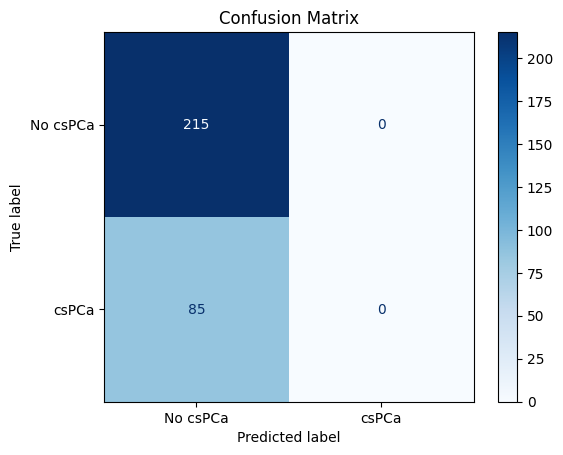

In [ ]:
model.eval()
y_true, y_pred, y_prob = [], [], []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = torch.sigmoid(model(images)).cpu().squeeze()
        y_prob.extend(outputs.numpy())
        preds = np.round(outputs.numpy())
        y_true.extend(labels.numpy())
        y_pred.extend(preds)

auc = roc_auc_score(y_true, y_prob)
accuracy = accuracy_score(y_true, y_pred)
cm = confusion_matrix(y_true, y_pred)

print(f"AUC: {auc:.4f}, Accuracy: {accuracy:.4f}")
print("Confusion Matrix:")
print(cm)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No csPCa", "csPCa"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()
